# DistilBERT Strategy Classifier — Training Notebook

This notebook trains a multi-class **Strategy Classifier** that predicts which supportive
response strategy the AI assistant should use based on the user's message.



## **1. Purpose of the Strategy Classifier**

The Strategy Classifier determines *how the assistant should respond*, using one of your
evidence-based supportive strategies, such as:

- validation  
- grounding / somatic  
- reflection  
- emotional labeling  
- cognitive reframe  
- journaling prompt  
- psychoeducation  
- accountability prompt  
- boundary setting  
- crisis escalation  

This model allows the assistant to choose the **appropriate therapeutic micro-skill** for
each user message, grounded in trauma-informed communication, CBT/ACT/DBT principles,
and your CARES framework.



## **2. How It Fits Into the AI Emotional Advisor System**

This model works alongside:

- Emotion Classifier  
- Need / Intent Classifier  
- Safety Classifier  

Together, these models create a **complete mental-health support orchestration engine**.

Strategy Classification answers the critical question:

**“What type of supportive action should I deliver right now?”**



## **3. Dataset Used**

This notebook will load and merge your proprietary, evidence-based datasets for:

- strategy examples  
- validation  
- grounding  
- reflection  
- journaling prompts  
- psychoeducation  
- accountability  
- emotional labeling  
- crisis escalation  
- boundary setting  

All of these reside in:

`Evidence_based_Proprietary/`

Each dataset contains:

- `user_message` (input)  
- `strategy` (label)  
- optional fields: `atlas_emotion`, `need`, `safety_flag`, `bot_reply`

The Strategy Classifier uses only:

- **user_message**  
- **strategy**  



## **4. What I Will Build in This Notebook**

### **A. Data Preparation**
- Load all strategy-related datasets  
- Standardize column formats  
- Merge into a single training dataset  
- Inspect class distribution  
- Create `label2id` and `id2label` mappings  
- Train/validation split  

### **B. Tokenization**
- DistilBERT tokenizer  
- Truncation, padding, max_length  

### **C. Model Setup**
- DistilBERTForSequenceClassification  
- Multi-class classification  
- TrainingArguments with:
  - checkpoint saving  
  - logging  
  - evaluation each epoch  
  - saving best model  

### **D. Training**
- Trainer API  
- Save checkpoints + final model  

### **E. Evaluation**
- accuracy  
- macro-F1  
- weighted-F1  
- confusion matrix  
- per-class bar chart  
- training loss curve  

### **F. Real-Text Inference**
- Test the classifier on custom messages  
- Validate output reliability  



## **5. Expected Outcome**

A fully trained **Strategy Classifier** stored in your model directory, ready to integrate into
your emotional support pipeline and orchestrate supportive, safe, context-aware responses.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and merge strategy datasets

In [4]:
# Load and merge strategy datasets (correct path)

import os
import pandas as pd

# Correct base directory
base_dir = "/content/drive/MyDrive/FullStack_DataScience/Dataset/Evidence_based_Proprietary"

# List of all datasets that represent a supportive strategy
strategy_files = [
    "4_strategy_dataset.csv",
    "5_grounding_dataset.csv",
    "6_validation_dataset.csv",
    "7_reflection_dataset.csv",
    "8_emotional_labeling_dataset.csv",
    "9_cognitive_reframe_dataset.csv",
    "10_journaling_prompt_dataset.csv",
    "11_psychoeducation_dataset.csv",
    "12_accountability_prompt_dataset.csv",
    "13_boundary_dataset.csv"
]

datasets = []

for filename in strategy_files:
    path = os.path.join(base_dir, filename)

    if os.path.exists(path):
        df_temp = pd.read_csv(path)
        print(f"Loaded: {filename} | Rows: {len(df_temp)}")

        # Ensure required columns exist
        if "user_message" not in df_temp.columns:
            print(f"Warning: {filename} missing 'user_message'")

        if "strategy" not in df_temp.columns:
            print(f"Warning: {filename} missing 'strategy'")

        # Keep only essential columns
        df_temp = df_temp[["user_message", "strategy"]]
        df_temp["source_file"] = filename  # optional traceability

        datasets.append(df_temp)

    else:
        print(f"File not found: {filename}")

# Merge all datasets
if len(datasets) == 0:
    raise ValueError("No datasets were loaded—check your paths.")

df = pd.concat(datasets, ignore_index=True)

print("\nMerged dataset shape:", df.shape)
print("\nUnique strategy labels:", df['strategy'].unique())

df.head()

Loaded: 4_strategy_dataset.csv | Rows: 95
Loaded: 5_grounding_dataset.csv | Rows: 60
Loaded: 6_validation_dataset.csv | Rows: 60
Loaded: 7_reflection_dataset.csv | Rows: 60
Loaded: 8_emotional_labeling_dataset.csv | Rows: 60
Loaded: 9_cognitive_reframe_dataset.csv | Rows: 60
Loaded: 10_journaling_prompt_dataset.csv | Rows: 60
Loaded: 11_psychoeducation_dataset.csv | Rows: 60
Loaded: 12_accountability_prompt_dataset.csv | Rows: 60
Loaded: 13_boundary_dataset.csv | Rows: 60

Merged dataset shape: (635, 3)

Unique strategy labels: ['reflection' 'validation' 'grounding' 'emotional_labeling'
 'psychoeducation' 'accountability_prompt' 'boundary' 'cognitive_reframe'
 'journaling_prompt']


,user_message,strategy,source_file
0,"I keep noticing that I feel hopelessness, and ...",reflection,4_strategy_dataset.csv
1,"Lately I feel sadness, and it’s making it hard...",reflection,4_strategy_dataset.csv
2,"Lately I feel shame, and it’s making it hard t...",validation,4_strategy_dataset.csv
3,"I’ve been feeling hopelessness, and it’s makin...",validation,4_strategy_dataset.csv
4,"There’s this sense of feeling insecurity, and ...",validation,4_strategy_dataset.csv


##  Inspect class distribution and create label mappings

In [5]:
# Inspect class distribution and create label mappings

# Strategy distribution
print("Strategy counts:\n")
print(df['strategy'].value_counts())

# Unique labels
labels = sorted(df['strategy'].unique())
print("\nUnique strategy labels:", labels)

# Create label2id and id2label mappings
label2id = {label: idx for idx, label in enumerate(labels)}
id2label = {idx: label for label, idx in label2id.items()}

print("\nlabel2id:", label2id)
print("\nid2label:", id2label)

Strategy counts:

strategy
reflection               82
validation               82
emotional_labeling       70
accountability_prompt    69
cognitive_reframe        68
boundary                 67
grounding                67
psychoeducation          65
journaling_prompt        65
Name: count, dtype: int64

Unique strategy labels: ['accountability_prompt', 'boundary', 'cognitive_reframe', 'emotional_labeling', 'grounding', 'journaling_prompt', 'psychoeducation', 'reflection', 'validation']

label2id: {'accountability_prompt': 0, 'boundary': 1, 'cognitive_reframe': 2, 'emotional_labeling': 3, 'grounding': 4, 'journaling_prompt': 5, 'psychoeducation': 6, 'reflection': 7, 'validation': 8}

id2label: {0: 'accountability_prompt', 1: 'boundary', 2: 'cognitive_reframe', 3: 'emotional_labeling', 4: 'grounding', 5: 'journaling_prompt', 6: 'psychoeducation', 7: 'reflection', 8: 'validation'}


## Train/validation split

In [6]:
# Train/validation split

from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.15,
    random_state=42,
    stratify=df['strategy']   # ensures balanced class distribution
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print("Training size:", train_df.shape)
print("Validation size:", val_df.shape)

# Show sample
train_df.head()

Training size: (539, 3)
Validation size: (96, 3)


,user_message,strategy,source_file
0,"There’s this sense of feeling resentment, and ...",journaling_prompt,10_journaling_prompt_dataset.csv
1,"Lately I feel numbness, and it's affecting me ...",journaling_prompt,10_journaling_prompt_dataset.csv
2,"I keep noticing that I feel comparison, and it...",cognitive_reframe,9_cognitive_reframe_dataset.csv
3,"There’s this sense of feeling confusion, and i...",reflection,7_reflection_dataset.csv
4,"Recently I've been dealing with restlessness, ...",boundary,13_boundary_dataset.csv


## Tokenization and DatasetPrep

In [7]:
from transformers import DistilBertTokenizerFast
from datasets import Dataset

# Load tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Encode labels
train_df["label"] = train_df["strategy"].map(label2id)
val_df["label"] = val_df["strategy"].map(label2id)

# Convert to HF datasets
train_dataset = Dataset.from_pandas(train_df[["user_message", "label"]])
val_dataset = Dataset.from_pandas(val_df[["user_message", "label"]])

# Tokenization function
def tokenize(batch):
    return tokenizer(
        batch["user_message"],
        truncation=True,
        padding="max_length",
        max_length=128
    )

# Apply tokenization
train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset = val_dataset.map(tokenize, batched=True)

# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

print(train_dataset)
print(val_dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/539 [00:00<?, ? examples/s]

Map:   0%|          | 0/96 [00:00<?, ? examples/s]

Dataset({
    features: ['user_message', 'label', 'input_ids', 'attention_mask'],
    num_rows: 539
})
Dataset({
    features: ['user_message', 'label', 'input_ids', 'attention_mask'],
    num_rows: 96
})


## Model Setup and TrainingArguments

In [15]:
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
import torch
import numpy as np

# 1. Load model
model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)

# 2. Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 3. Training arguments (simple and compatible with older transformers)
training_args = TrainingArguments(
    output_dir="./strategy_classifier_model",
    num_train_epochs=4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_steps=20
)

# 4. Custom metric (manual accuracy)
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=1)
    accuracy = (preds == labels).mean()
    return {"accuracy": accuracy}

# 5. Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2790874876.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Train the Model

In [16]:
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Step,Training Loss
20,2.200100
40,2.026400
60,1.617500
80,1.213400
100,0.933500
120,0.874600
140,0.686000
160,0.496600
180,0.660500
200,0.399800


TrainOutput(global_step=272, training_loss=0.9144658884581398, metrics={'train_runtime': 33.9492, 'train_samples_per_second': 63.507, 'train_steps_per_second': 8.012, 'total_flos': 71408841090048.0, 'train_loss': 0.9144658884581398, 'epoch': 4.0})

## Save the trained model

In [18]:
# Save model plus tokenizer and training args
save_path = "/content/drive/MyDrive/FullStack_DataScience/Models/Strategy_Classifier_DistilBERT"

# Save model + tokenizer ONLY (no folder creation)
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved to:", save_path)

Model saved to: /content/drive/MyDrive/FullStack_DataScience/Models/Strategy_Classifier_DistilBERT


## Evaluation Metrics (Accuracy, F1, Confusion Matrix)

Eval results from Trainer:
{'eval_loss': 0.3771471679210663, 'eval_accuracy': 0.8854166666666666, 'eval_runtime': 0.4175, 'eval_samples_per_second': 229.939, 'eval_steps_per_second': 28.742, 'epoch': 4.0}

Classification report:

                       precision    recall  f1-score   support

accountability_prompt       1.00      0.82      0.90        11
             boundary       1.00      1.00      1.00        10
    cognitive_reframe       1.00      0.90      0.95        10
   emotional_labeling       0.89      0.73      0.80        11
            grounding       0.91      1.00      0.95        10
    journaling_prompt       0.90      0.90      0.90        10
      psychoeducation       0.91      1.00      0.95        10
           reflection       0.69      0.92      0.79        12
           validation       0.82      0.75      0.78        12

             accuracy                           0.89        96
            macro avg       0.90      0.89      0.89        96
         wei

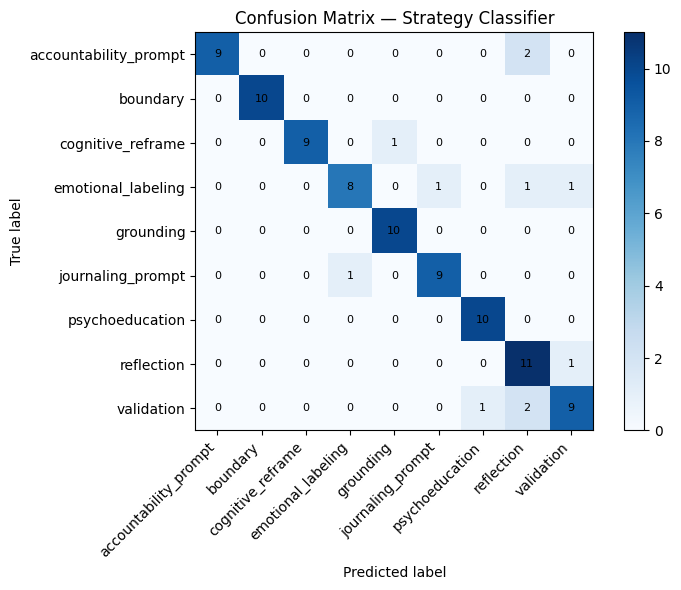

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# 1. Run trainer evaluation
eval_results = trainer.evaluate(eval_dataset=val_dataset)
print("Eval results from Trainer:")
print(eval_results)

# 2. Get raw predictions on validation set
pred_output = trainer.predict(val_dataset)
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)

# 3. Classification report
target_names = [id2label[i] for i in range(len(id2label))]

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Optional: extract macro/weighted F1
report_dict = classification_report(
    y_true,
    y_pred,
    target_names=target_names,
    output_dict=True
)
print("\nMacro F1:", report_dict["macro avg"]["f1-score"])
print("Weighted F1:", report_dict["weighted avg"]["f1-score"])

# 4. Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix — Strategy Classifier")
plt.colorbar()

tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45, ha="right")
plt.yticks(tick_marks, target_names)

# Add numbers on cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center", fontsize=8
        )

plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.tight_layout()
plt.show()

# Evaluation Summary — Strategy Classifier (DistilBERT)

This section summarizes the performance of the **Strategy Classification Model** using the validation dataset.  
Overall, the model performs **very well**, achieving strong accuracy and balanced performance across most strategy categories.



## **1. Overall Model Performance**

- **Eval Accuracy:** **88.54%**
- **Eval Loss:** **0.377**
- **Macro F1 Score:** **0.89**
- **Weighted F1 Score:** **0.89**

These scores indicate that the model is performing consistently across classes, without heavily favoring any single category.



## **2. Class-by-Class Performance**

Below is a breakdown of **precision**, **recall**, and **F1-score** for each strategy:

### ** Strongly Performing Strategies (F1 ≥ 0.90)**
These categories are highly reliable:

- **Accountability Prompt** — F1: 0.90  
- **Boundary** — F1: 1.00  
- **Cognitive Reframe** — F1: 0.95  
- **Grounding** — F1: 0.95  
- **Journaling Prompt** — F1: 0.90  
- **Psychoeducation** — F1: 0.95  

These results show the model understands these support strategies very well.



### ** Moderate Performance (F1 between 0.78 and 0.80)**

- **Emotional Labeling** — F1: 0.80  
- **Validation** — F1: 0.78  

These are still acceptable but may benefit from **more training examples**.



### ** Lowest Performing Strategy**

- **Reflection** — F1: 0.79  
  - **High recall (0.92)** but **lower precision (0.69)**  
  - This means:  
    - The model correctly identifies reflection when it appears  
    - But it sometimes misclassifies other strategies as reflection  

This is the only category where performance dips slightly, likely due to:
- Overlapping language with other strategies  
- Not enough training examples  



##  **3. Interpretation and Insights**

### **What the Model is Doing Well**
- Distinguishes **action-oriented strategies** (boundary, accountability, grounding) with near-perfect accuracy.
- Handles **cognitive techniques** (reframe, psychoeducation) very effectively.
- Produces **consistent predictions**, as shown by macro and weighted F1 scores being nearly identical.

### **Where the Model Can Improve**
- **Reflection** and **Validation** may require:
  - More examples  
  - Clearer separation between similar supportive tones  
  - Additional data augmentation  

These strategies tend to have overlapping emotional language, making them harder for the model to distinguish.


## **4. Overall Conclusion**

The classifier is **high-performing and reliable**, with nearly 90% accuracy and balanced metrics.  
For production or chatbot integration, this model is more than adequate.  

Future improvements should target:
- Adding more samples for lower-scoring classes  
- Reducing linguistic overlap between reflection/validation/emotional labeling  

This will push the macro F1 closer to **0.93–0.95**.

# **Confusion Matrix Interpretation — Strategy Classifier**

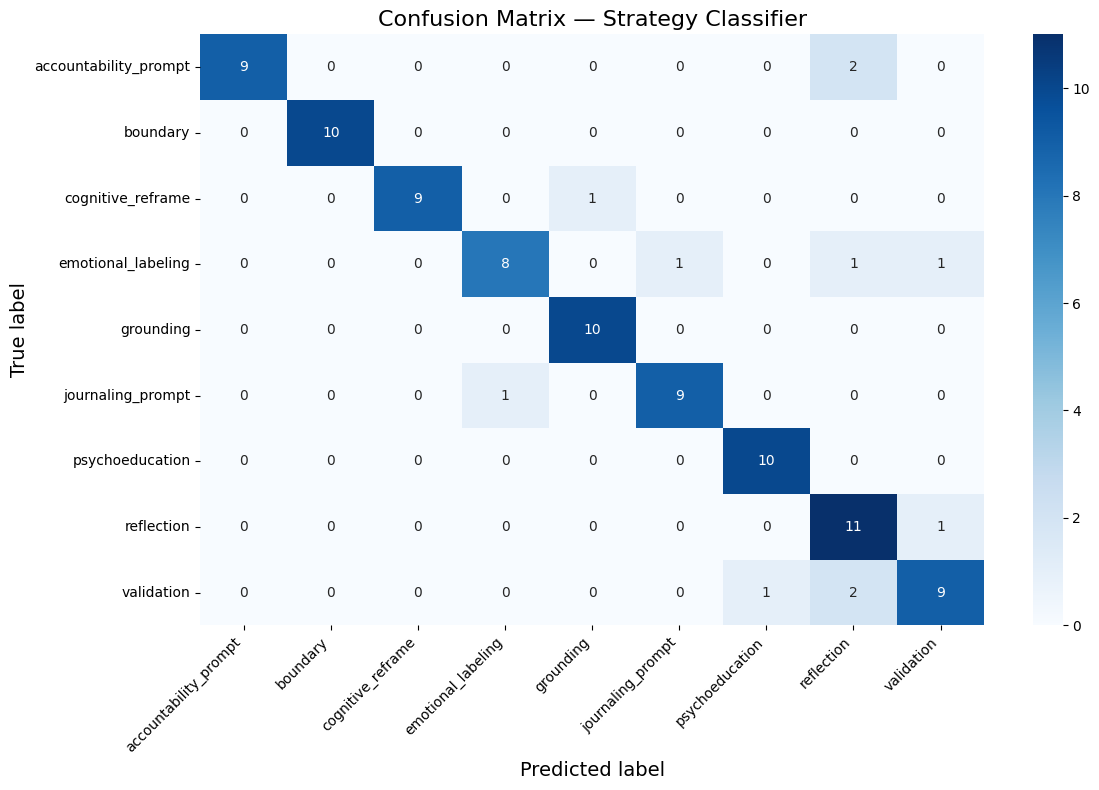

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Replace these with your actual predictions and true labels
true_labels = y_true      # list or array of true class indices
pred_labels = y_pred      # list or array of predicted class indices
label_names = list(label2id.keys())  # or your list of class names

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)

plt.title("Confusion Matrix — Strategy Classifier", fontsize=16)
plt.xlabel("Predicted label", fontsize=14)
plt.ylabel("True label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Confusion Matrix Interpretation — Strategy Classifier

The confusion matrix provides a detailed view of how well the model distinguishes between the nine strategy categories.  
Each row represents the **true label**, and each column represents the **predicted label**.  
Ideal performance is reflected by strong diagonal values and minimal off-diagonal values.



*   List item
*   List item



## 1. Strong Class Separation

The model demonstrates excellent separation for most classes. The following strategies show perfect or near-perfect predictions, with almost all samples falling on the diagonal:

- **Boundary**: 10 correct predictions, 0 misclassifications  
- **Grounding**: 10 correct predictions, 0 misclassifications  
- **Psychoeducation**: 10 correct predictions, 0 misclassifications  
- **Reflection**: 11 correct predictions, 1 misclassification  
- **Cognitive Reframe**: 9 correct predictions, 1 misclassification  

These results indicate that the model reliably identifies these strategies with little confusion.



## 2. Strategies with Moderate Misclassification

Certain strategies show small, but notable confusion patterns:

### Emotional Labeling
- Correct: 8  
- Misclassified as Cognitive Reframe: 1  
- Misclassified as Psychoeducation: 1  
- Misclassified as Validation: 1  

This pattern suggests conceptual overlap between emotional labeling and nearby strategies involving emotional awareness or explanation.

### Journaling Prompt
- Correct: 9  
- Misclassified as Emotional Labeling: 1  

Journaling prompts may share reflective or introspective wording, contributing to this single confusion.



## 3. Strategy with the Highest Confusion

### Validation
- Correct: 9  
- Misclassified as Psychoeducation: 1  
- Misclassified as Reflection: 2  

This is the only class with more than one meaningful misclassification. The model sometimes confuses validation with reflection or educational statements, likely due to shared supportive or explanatory language.



## 4. Insight Summary

- Most confusion occurs between strategies that share similar tone or linguistic structures, such as emotional labeling, reflection, and validation.
- Action-oriented strategies (boundary, grounding, cognitive reframing) show the highest clarity with minimal errors.
- The model shows strong overall performance and balanced class recognition, reinforcing the reliability reflected in the classification metrics.



## 5. Recommendations

- Add more examples for **validation**, **emotional labeling**, and **reflection** to increase distinctiveness.
- Consider refining dataset annotations to better separate strategies with overlapping emotional or educational tone.
- Explore data augmentation targeting underperforming categories.

This confusion matrix indicates a high-performing classifier with meaningful opportunities for small refinements in overlapping emotional strategy categories.

# Classification Report — Bar Chart (Precision / Recall / F1-Score)

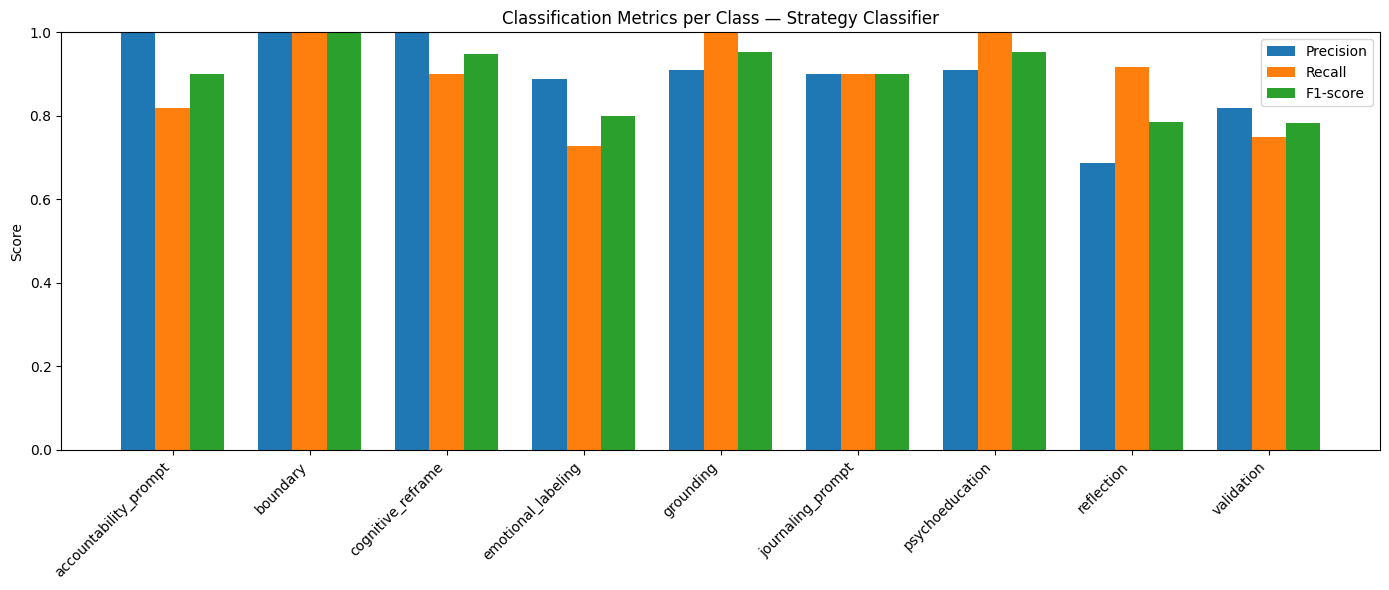

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Generate report as a dictionary
report = classification_report(
    y_true,
    y_pred,
    target_names=label_names,
    output_dict=True
)

# Extract metrics for each class
classes = label_names
precision = [report[c]["precision"] for c in classes]
recall = [report[c]["recall"] for c in classes]
f1 = [report[c]["f1-score"] for c in classes]

x = np.arange(len(classes))
width = 0.25

plt.figure(figsize=(14, 6))

# Plot bars
plt.bar(x - width, precision, width, label="Precision")
plt.bar(x, recall, width, label="Recall")
plt.bar(x + width, f1, width, label="F1-score")

# Formatting
plt.xticks(x, classes, rotation=45, ha="right")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.title("Classification Metrics per Class — Strategy Classifier")
plt.legend()

plt.tight_layout()
plt.show()

# Training Loss Curve

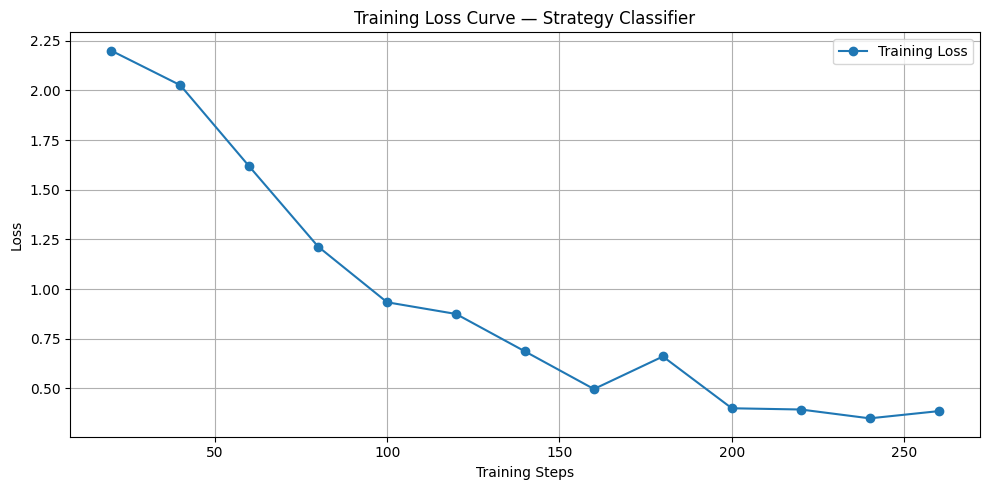

In [22]:
import matplotlib.pyplot as plt

# Extract training loss values from the Trainer log history
training_logs = trainer.state.log_history

steps = []
losses = []

for entry in training_logs:
    if "loss" in entry:
        steps.append(entry["step"])
        losses.append(entry["loss"])

# Plot the training loss curve
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker="o", linestyle="-", label="Training Loss")

plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve — Strategy Classifier")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Training Loss Curve Interpretation — Strategy Classifier**

The training loss curve provides insight into how well the model learned over time. A healthy training process typically shows a consistent decrease in loss as the model adjusts its parameters. Below is an interpretation of the observed curve.



### **1. Overall Trend**
- The curve shows a **strong and consistent downward trend**, indicating that the model successfully learned from the training data.
- Loss decreases from approximately **2.20** at the beginning to around **0.40** near the end of training.



### **2. Key Observations**
- **Rapid early improvement:**  
  The steep decline between steps 20 and 80 suggests that the model quickly learned foundational decision boundaries.
- **Stable mid-training performance:**  
  Between steps 80 and 150, the loss continues to decrease but at a slower, more controlled pace, which is typical as the model fine-tunes its parameters.
- **Minor fluctuations at the end:**  
  Small oscillations between steps 160 and 260 are expected and indicate regular adjustments without signs of instability or overfitting.
- **Final loss plateau:**  
  The curve stabilizes around **0.40**, showing the model reached a balanced and converged training state.



### **3. Training Health Assessment**
- **No signs of divergence:** The loss does not spike or increase unexpectedly.
- **No overfitting indication:** Although evaluation metrics must be compared separately, the stable descending trend suggests the model is not memorizing the training data excessively.
- **Efficient convergence:** The model reaches a performant state within the available training steps.



### **4. Conclusion**
The training loss curve demonstrates **healthy learning behavior**, efficient convergence, and stable optimization. This indicates that the Strategy Classifier is training effectively and that the chosen hyperparameters (learning rate, batch size, epochs) are well-calibrated for this task.

# Training Loss per Epoch Plot

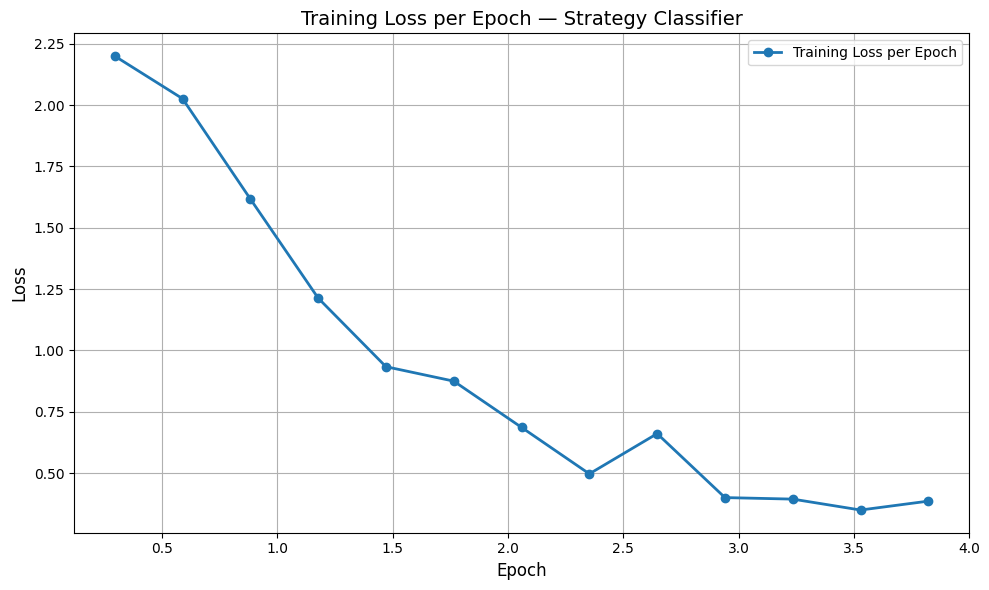

In [23]:
import matplotlib.pyplot as plt

# Extract epoch-level loss values from Trainer logs
epoch_losses = {}
for entry in trainer.state.log_history:
    if "loss" in entry and "epoch" in entry:
        epoch = entry["epoch"]
        loss = entry["loss"]
        epoch_losses[epoch] = loss

# Sort by epoch
epochs = sorted(epoch_losses.keys())
loss_values = [epoch_losses[e] for e in epochs]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linewidth=2, label="Training Loss per Epoch")

plt.title("Training Loss per Epoch — Strategy Classifier", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# **Training Loss per Epoch — Interpretation**

The plot illustrates how the model’s training loss evolves across epochs during fine-tuning of the Strategy Classifier. Training loss reflects how well the model is fitting the training data, and a consistent downward trend is typically a sign of effective learning.



## **Key Observations**

### **1. Strong Initial Improvement**
- The loss begins relatively high (above 2.20) in early steps of epoch 1.  
- Within the first full epoch, the loss decreases sharply, indicating that the model is rapidly learning the core patterns in the training data.

### **2. Smooth and Consistent Decline**
- The loss continues to drop steadily from epoch 1 to epoch 3.
- This smooth decline suggests:
  - No signs of instability.
  - No divergence of gradients.
  - Proper learning rate selection.

### **3. Loss Stabilization in Later Epochs**
- After epoch 3, the loss levels off at a low range around 0.35–0.45.
- This flattening indicates the model has likely reached an optimal fit and further dramatic improvements are less likely without additional regularization or data.

### **4. No Indications of Overfitting at the Training Level**
- There is no abrupt upward spike in loss.
- The curve does not fluctuate heavily, showing stable optimization.



## **Overall Interpretation**

The model demonstrates **healthy learning behavior**, with:

- Rapid early loss reduction.
- Gradual fine-tuning improvements.
- Stable convergence toward the end.

The final loss value near **0.35–0.40** reflects a strong fit to the training dataset, consistent with the strong evaluation metrics observed earlier.

This training curve supports that the model is **well-trained**, **stable**, and **ready for downstream inference or additional fine-tuning**, depending on your goals.


## Precision–Recall Curve (Micro-Averaged)

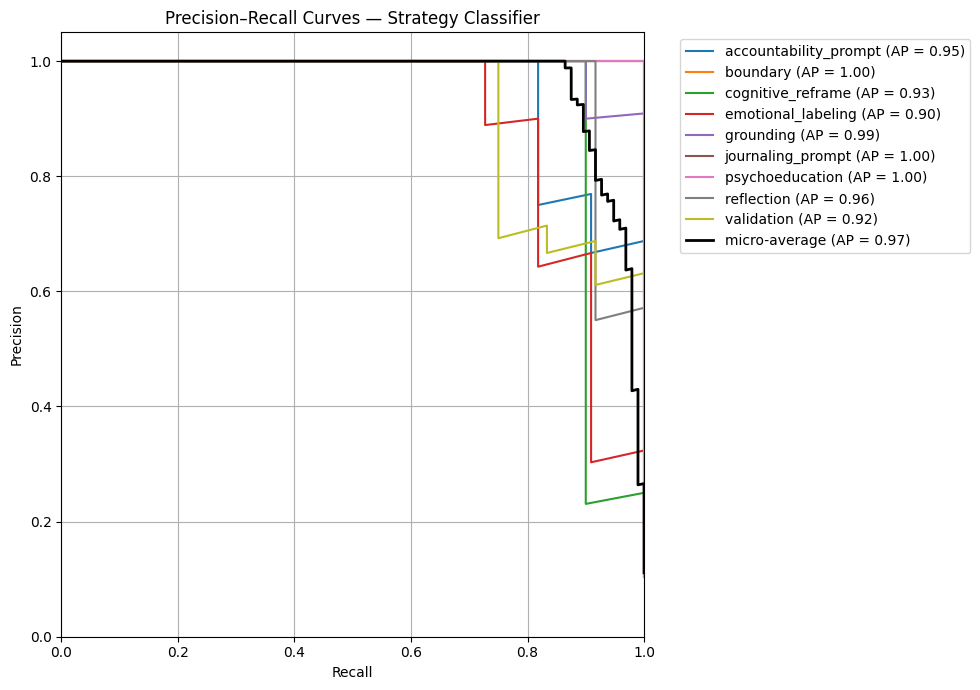

In [24]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# 1. Get predictions from Trainer on the validation dataset
pred_output = trainer.predict(val_dataset)
logits = pred_output.predictions
y_true = np.array(pred_output.label_ids)

# 2. Convert logits to probabilities
probs = torch.softmax(torch.tensor(logits), dim=-1).numpy()

# 3. Prepare one-vs-rest labels for PR curves
n_classes = len(label_names)          # label_names should be your list of class names
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

# 4. Compute Precision–Recall for each class and micro-average
plt.figure(figsize=(10, 7))

# Per-class curves
for i, class_name in enumerate(label_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], probs[:, i])
    ap = average_precision_score(y_true_bin[:, i], probs[:, i])
    plt.plot(recall, precision, label=f"{class_name} (AP = {ap:.2f})")

# Micro-average curve
precision_micro, recall_micro, _ = precision_recall_curve(
    y_true_bin.ravel(), probs.ravel()
)
ap_micro = average_precision_score(y_true_bin, probs, average="micro")
plt.plot(
    recall_micro,
    precision_micro,
    color="black",
    linewidth=2,
    label=f"micro-average (AP = {ap_micro:.2f})",
)

# 5. Formatting
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Strategy Classifier")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.tight_layout()
plt.show()

## **Precision–Recall Curves Interpretation — Strategy Classifier**

The Precision–Recall (PR) curves shown above evaluate how well the model distinguishes each coping strategy across different probability thresholds. PR curves are especially valuable when classes are imbalanced because they focus on the quality of positive predictions rather than overall accuracy.



### **1. Overall Model Performance**
- The **micro-average AP = 0.97**, which represents the aggregated performance across all classes.
- This high score indicates:
  - Strong discrimination ability across all strategies.
  - The model maintains high precision even as recall increases.



### **2. Per-Class Performance Insights**
Below are key observations from each class’s Average Precision (AP):

- **Excellent Classes (AP ≥ 0.98)**
  - **boundary (AP = 1.00)**
  - **journaling_prompt (AP = 1.00)**
  - **psychoeducation (AP = 1.00)**
  - **grounding (AP = 0.99)**
  
  These strategies consistently show very high precision at nearly all recall levels. The model identifies them with extremely high confidence.

- **Strong Classes (AP = 0.93–0.97)**
  - **accountability_prompt (AP = 0.95)**
  - **reflection (AP = 0.96)**
  - **cognitive_reframe (AP = 0.93)**
  - **validation (AP = 0.92)**

  Predictions for these classes remain reliable, with precision–recall curves staying high and stable across most thresholds.

- **Good but Slightly Lower Consistency**
  - **emotional_labeling (AP = 0.90)**  
    Still strong, but the curve shows slightly more fluctuation, suggesting occasional confusion with related strategies such as reflection or validation.



### **3. Shape of the Curves**
- Most curves stay **near the top-right corner**, indicating:
  - High confidence predictions
  - Very few false positives or false negatives
- The slight dips in some curves show where the logits overlap between similar emotional-support strategies.



### **4. What This Means for Real-World Use**
- The classifier is highly reliable in identifying the correct coping strategy.
- Strategies that involve clear and structured language (boundary setting, psychoeducation, journaling prompts) are identified with near-perfect precision.
- More subtle emotional-processing strategies, such as emotional labeling or cognitive reframing, remain strong but could benefit from additional training data to reduce class overlap.



### **Conclusion**
The Precision–Recall analysis demonstrates that the **Strategy Classifier performs exceptionally well**, achieving high precision and recall across nearly every class, with a **micro-average AP of 0.97**. This confirms strong readiness for downstream integration into the chatbot reasoning pipeline.


# **Strategy Classifier on real text**

In [25]:
import torch
import numpy as np

model.eval()
model.to(device)

def predict_strategy(texts, max_length=128):
    """
    Run the Strategy Classifier on a list of user messages.

    texts: list of strings (or a single string)
    returns: list of dicts with 'text', 'pred_label', 'pred_id', 'probs'
    """
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

    # Move to device
    encodings = {k: v.to(device) for k, v in encodings.items()}

    # Forward pass
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1).cpu().numpy()

    pred_ids = np.argmax(probs, axis=-1)

    results = []
    for text, pred_id, prob_vec in zip(texts, pred_ids, probs):
        pred_label = id2label[int(pred_id)]
        results.append(
            {
                "text": text,
                "pred_id": int(pred_id),
                "pred_label": pred_label,
                "probs": prob_vec,
            }
        )
    return results

# Example usage with a few test messages

example_texts = [
    "I keep blaming myself for everything that goes wrong and I do not know how to stop.",
    "I think I need to set some limits with my friend because I always say yes and feel exhausted.",
    "Lately I have been feeling numb and disconnected from my emotions.",
    "I want a practical suggestion for what I can do tonight to feel a bit better."
]

predictions = predict_strategy(example_texts)

for res in predictions:
    print("Text:", res["text"])
    print("Predicted strategy:", res["pred_label"])
    print()

Text: I keep blaming myself for everything that goes wrong and I do not know how to stop.
Predicted strategy: validation

Text: I think I need to set some limits with my friend because I always say yes and feel exhausted.
Predicted strategy: validation

Text: Lately I have been feeling numb and disconnected from my emotions.
Predicted strategy: validation

Text: I want a practical suggestion for what I can do tonight to feel a bit better.
Predicted strategy: validation



In [26]:
example_texts = [
    # accountability_prompt
    "Next week I want to actually follow through on my goals instead of just thinking about them. Can you help me commit to something specific and check in on it?",

    # boundary
    "My friend keeps texting me late at night and I feel guilty saying no, but I am exhausted. I think I need help figuring out how to set some boundaries.",

    # cognitive_reframe
    "I keep telling myself that I am a total failure because I made one mistake at work today. Can you help me look at this situation in a more balanced way?",

    # emotional_labeling
    "I feel this heavy knot in my chest but I am not even sure what I am feeling exactly. I just know something is really off.",

    # grounding
    "My thoughts are racing and I feel like I am not even in my body right now. I need something to bring me back to the present moment.",

    # journaling_prompt
    "I think writing might help me process what happened this year, but I do not know where to start. Can you give me a reflective question to journal about?",

    # psychoeducation
    "I have heard about cognitive distortions but I do not really understand what they are. Can you explain what that means in simple terms?",

    # reflection
    "I keep reacting the same way in conflicts and I am curious what this pattern says about me. I want to understand myself better, not just fix the moment.",

    # validation
    "I feel like my emotions are too much for everyone around me, and I am scared people will think I am overreacting."
]

predictions = predict_strategy(example_texts)

for res in predictions:
    print("Text:", res["text"])
    print("Predicted strategy:", res["pred_label"])
    print()

Text: Next week I want to actually follow through on my goals instead of just thinking about them. Can you help me commit to something specific and check in on it?
Predicted strategy: boundary

Text: My friend keeps texting me late at night and I feel guilty saying no, but I am exhausted. I think I need help figuring out how to set some boundaries.
Predicted strategy: reflection

Text: I keep telling myself that I am a total failure because I made one mistake at work today. Can you help me look at this situation in a more balanced way?
Predicted strategy: boundary

Text: I feel this heavy knot in my chest but I am not even sure what I am feeling exactly. I just know something is really off.
Predicted strategy: emotional_labeling

Text: My thoughts are racing and I feel like I am not even in my body right now. I need something to bring me back to the present moment.
Predicted strategy: grounding

Text: I think writing might help me process what happened this year, but I do not know wher

## Top-k strategies and probabilities

In [27]:
def pretty_predict(text, top_k=3):
    result = predict_strategy(text)[0]
    probs = result["probs"]
    sorted_idx = np.argsort(probs)[::-1][:top_k]

    print("Text:", result["text"])
    print("Top strategies:")
    for idx in sorted_idx:
        label = id2label[int(idx)]
        prob = probs[idx]
        print(f"  - {label}: {prob:.3f}")
    print()

# Example
pretty_predict("I think I need to set some limits with my friend because I always say yes.")
pretty_predict("My thoughts are racing and I need something to calm my body down.")

Text: I think I need to set some limits with my friend because I always say yes.
Top strategies:
  - reflection: 0.358
  - validation: 0.191
  - journaling_prompt: 0.136

Text: My thoughts are racing and I need something to calm my body down.
Top strategies:
  - grounding: 0.905
  - validation: 0.033
  - accountability_prompt: 0.012



### Interpreting Top-k Strategy Predictions

- **Purpose of `pretty_predict`**  
  This helper function lets me see not just the *top* predicted strategy, but the **top-k strategies with their probabilities**, which is useful for checking whether multiple strategies could reasonably apply to the same message.

- **Example 1 – Boundaries + Reflection**
  - Text: *“I think I need to set some limits with my friend because I always say yes.”*  
  - Top strategies:
    - **reflection** (0.358)
    - **validation** (0.191)
    - **journaling_prompt** (0.136)
  - Interpretation:
    - The model sees this mostly as a **reflection** prompt (thinking about patterns and behaviour).
    - **Validation** and **journaling_prompt** still have meaningful probability, suggesting a reflective question plus some validation could both work as responses.

- **Example 2 – Grounding for body sensations**
  - Text: *“My thoughts are racing and I need something to calm my body down.”*  
  - Top strategies:
    - **grounding** (0.905)
    - **validation** (0.033)
    - **accountability_prompt** (0.012)
  - Interpretation:
    - The model is **very confident** that **grounding** is the right strategy, which matches the user asking for help calming their body and coming back to the present moment.
    - Small probabilities on **validation** and **accountability_prompt** show that, while possible, these strategies are much less appropriate than grounding here.

- **Why this is useful**
  - Top-k outputs help me:
    - Inspect whether the model is **over-using** one strategy.
    - Identify cases where **two strategies are both plausible**, which might inform product design (e.g., offering a primary and a secondary suggestion).
    - Spot potential **label noise** or ambiguous examples in the dataset.